# Import bibliotek

In [ ]:
! pip install spotipy

In [ ]:
import pandas as pd
import numpy as np
import spotipy
import nltk

## 1. Przygotowanie zbioru danych - 79 genres dataset

In [ ]:
artist_path = "/content/drive/MyDrive/Magisterka/artists-data.csv"
lyrics_path = "/content/drive/MyDrive/Magisterka/lyrics-data.csv"
tcc_path = "/content/drive/MyDrive/Magisterka/tcc_ceds_music.csv"
train_multilungual_dataset = "/content/drive/MyDrive/Magisterka/train.csv"
test_multilungual_dataset = "/content/drive/MyDrive/Magisterka/test.csv"

In [ ]:
artist_data = pd.read_csv(artist_path)
lyrics_data = pd.read_csv(lyrics_path)
tcc_data = pd.read_csv(tcc_path)

In [ ]:
artist_data.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [ ]:
lyrics_data

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt
...,...,...,...,...,...
379926,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en
379927,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en
379928,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en
379929,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en


<Axes: xlabel='language'>

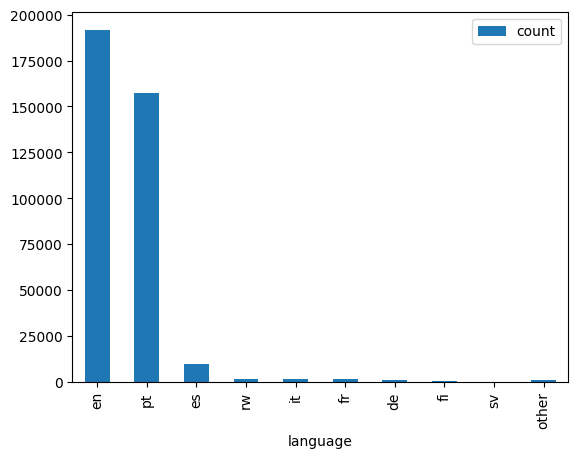

In [ ]:
def language_distribution(language_column: str, df: pd.DataFrame, cut_value: int = 100):
  language_distribution = df[language_column].value_counts()
  counts_below_100 = language_distribution[language_distribution < cut_value]
  other_count = counts_below_100.sum()
  language_distribution = language_distribution[language_distribution >= cut_value]
  language_distribution['other'] = other_count
  language_distribution=language_distribution.reset_index()
  return language_distribution.plot.bar(x='language', y='count')

language_distribution('language', lyrics_data)

In [ ]:
# Leave only english lyrics
lyrics_data = lyrics_data[lyrics_data['language'] == 'en']

<Axes: xlabel='language'>

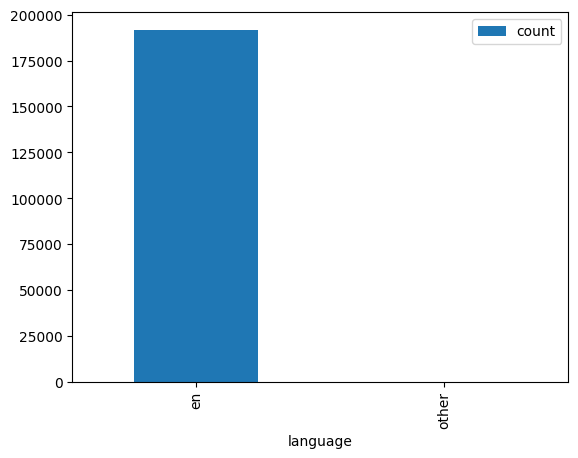

In [ ]:
language_distribution('language', lyrics_data)

In [ ]:
# Merge with artost data to get artist name
merged_df = pd.merge(lyrics_data, artist_data, left_on='ALink', right_on='Link', how='left')

In [ ]:
genres_dataset = merged_df[['SName', 'Artist','Lyric','Genres']]

In [ ]:
genres_dataset.head()

,SName,Artist,Lyric,Genres
0,Careless Whisper,Ivete Sangalo,I feel so unsure\nAs I take your hand and lead...,Pop; Axé; Romântico
1,Could You Be Loved / Citação Musical do Rap: S...,Ivete Sangalo,"Don't let them fool, ya\nOr even try to school...",Pop; Axé; Romântico
2,Cruisin' (Part. Saulo),Ivete Sangalo,"Baby, let's cruise, away from here\nDon't be c...",Pop; Axé; Romântico
3,Easy,Ivete Sangalo,"Know it sounds funny\nBut, I just can't stand ...",Pop; Axé; Romântico
4,For Your Babies (The Voice cover),Ivete Sangalo,You've got that look again\nThe one I hoped I ...,Pop; Axé; Romântico


In [ ]:
# Split the genres column into separate rows
genres_dataset['Genres'] = genres_dataset['Genres'].str.replace(' ', '').str.split(';')

<ipython-input-13-a2302d2f7ec4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_dataset['Genres'] = genres_dataset['Genres'].str.replace(' ', '').str.split(';')


In [ ]:
genres_dataset = genres_dataset.explode('Genres')

In [ ]:
# Perform one-hot encoding on the 'Genres' column
one_hot_encoded_genres = pd.get_dummies(genres_dataset['Genres'])
df_with_one_hot_genres = pd.concat([genres_dataset, one_hot_encoded_genres], axis=1)


Po przeprowadzeniu one-hot-encoding wyciągamy 10 najbardziej popularnych gatunków



In [ ]:
aggregated_genres = df_with_one_hot_genres.groupby(['SName','Artist']).sum().reset_index()

In [ ]:
aggregated_genres

,SName,Artist,Lyric,Genres,Axé,BlackMusic,Blues,BossaNova,COLETÂNEA,Chillout,...,SoulMusic,SurfMusic,Tecnopop,Trance,Trap,TrilhaSonora,Trip-Hop,TropicalHouse,VelhaGuarda,WorldMusic
0,"""Amon"" Belongs To ""Them""",King Diamond,Today My Mother will return to My house\nAnd a...,HeavyMetalClassicRockAxé,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"""E"" Train",Jonny Lang,"Take the ""E"" train babe\ntake the easy train t...",BluesPop/RockRock,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"""The Sound Of Music"" Tribute (Oscars 2015)",Lady Gaga,The hills are alive with the sound of music\nW...,DancePopPop/Rock,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"""cassius"" Love Vs. ""sonny"" Wilson",The Beach Boys,"Hi, this is Al. This scene takes place at a ty...",SurfMusicRock,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,"""like seeing spiders running riot on your love...",Bring Me The Horizon,I got a feeling that I cannot seem to shake\nS...,RockHardcoreHeavyMetal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191372,⦵ (Music of the Spheres),Coldplay,[Instrumental]\nMusic of the spheres[Instrumen...,Pop/RockPianoRockSoftRock,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191373,あなたがいなくて寂しいです(Missyou),Matheus Hardke,Everything breaks down\nIt is inevitable\nBut ...,Pop/Rock,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191374,イントロ(Intro),Matheus Hardke,Airplanes by the sky\nTonight\nNo makeup in sa...,Pop/Rock,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191375,追悼に戻る (Back To Mournin'),Matheus Hardke,I don't know what the rules are of it\nBut my ...,Pop/Rock,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
genre_counts = aggregated_genres.iloc[:, 4:].sum(axis=0)

In [ ]:
x = genre_counts.reset_index(name='Amount')
x = x.sort_values(by='Amount', ascending=False)
x = x.rename(columns={'index':'Genre'})
x.Genre.to_list()

['Rock',
 'Pop',
 'Pop/Rock',
 'HeavyMetal',
 'HipHop',
 'Indie',
 'Romântico',
 'HardRock',
 'Rap',
 'R&B',
 'RockAlternativo',
 'BlackMusic',
 'Dance',
 'Folk',
 'Country',
 'PunkRock',
 'SoulMusic',
 'Electronica',
 'Gospel/Religioso',
 'Hardcore',
 'TrilhaSonora',
 'Blues',
 'Gótico',
 'SoftRock',
 'Progressivo',
 'Jazz',
 'Tecnopop',
 'Pós-Punk',
 'Reggae',
 'Rockabilly',
 'NewWave',
 'Pop/Punk',
 'Disco',
 'Grunge',
 'Funk',
 'Psicodelia',
 'Clássico',
 'Instrumental',
 'SurfMusic',
 'House',
 'Emocore',
 'Axé',
 'ClassicRock',
 'COLETÂNEA',
 'J-Pop/J-Rock',
 'Infantil',
 'Trip-Hop',
 'Ska',
 'NewAge',
 'Industrial',
 'Chillout',
 'PianoRock',
 'Power-Pop',
 'MPB',
 'WorldMusic',
 'Trance',
 'K-Pop/K-Rock',
 'FunkCarioca',
 'Metal',
 'BossaNova',
 'VelhaGuarda',
 'Sertanejo',
 'TropicalHouse',
 'JovemGuarda',
 'Post-Rock',
 'Trap',
 'Lo-fi',
 'Samba',
 'Fado',
 'Reggaeton',
 'Pagode',
 'Forró',
 'Kizomba',
 'ElectroSwing',
 'Regional']

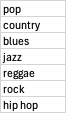

In [ ]:
top_10_genres = genre_counts.nlargest(10)
selected_genres = top_10_genres.index.tolist()
to_be_removed = {'Romântico', 'R&B', 'HardRock','Pop/Rock'}
selected_genres = [item for item in selected_genres if item not in to_be_removed]
selected_genres += ['Country', 'Blues', 'Jazz', 'Reggae']

In [ ]:
selected_genres

['Rock',
 'Pop',
 'HeavyMetal',
 'HipHop',
 'Indie',
 'Rap',
 'Country',
 'Blues',
 'Jazz',
 'Reggae']

In [ ]:
genres_df = aggregated_genres[['SName', 'Artist','Lyric'] + selected_genres]

In [ ]:
genres_df_filtered = genres_df[~(genres_df[selected_genres] == 0).all(axis=1)]

In [ ]:
filtered_df = genres_df[(genres_df['Rock'] == 0) | (genres_df[selected_genres].sum(axis=1) != genres_df['Rock'])]

> Tak prezentuje sie rozkład naszych danych z pierwszej bazy:

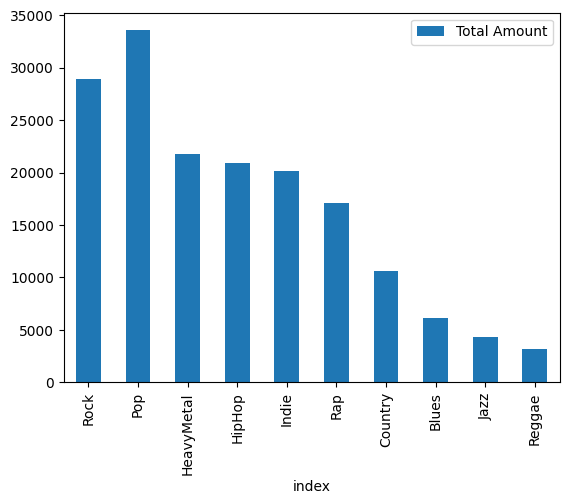

In [ ]:
genre_counts = filtered_df.iloc[:, 3:].sum(axis=0)
genre_plot = genre_counts.reset_index(name ='Total Amount').plot.bar(x='index')

In [ ]:
filtered_df

,SName,Artist,Lyric,Rock,Pop,HeavyMetal,HipHop,Indie,Rap,Country,Blues,Jazz,Reggae
0,"""Amon"" Belongs To ""Them""",King Diamond,Today My Mother will return to My house\nAnd a...,0,0,1,0,0,0,0,0,0,0
1,"""E"" Train",Jonny Lang,"Take the ""E"" train babe\ntake the easy train t...",1,0,0,0,0,0,0,1,0,0
2,"""The Sound Of Music"" Tribute (Oscars 2015)",Lady Gaga,The hills are alive with the sound of music\nW...,0,1,0,0,0,0,0,0,0,0
4,"""like seeing spiders running riot on your love...",Bring Me The Horizon,I got a feeling that I cannot seem to shake\nS...,1,0,1,0,0,0,0,0,0,0
5,#1,Animal Collective,I caught you in the eye\nThat disconnected tro...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191372,⦵ (Music of the Spheres),Coldplay,[Instrumental]\nMusic of the spheres[Instrumen...,0,0,0,0,0,0,0,0,0,0
191373,あなたがいなくて寂しいです(Missyou),Matheus Hardke,Everything breaks down\nIt is inevitable\nBut ...,0,0,0,0,0,0,0,0,0,0
191374,イントロ(Intro),Matheus Hardke,Airplanes by the sky\nTonight\nNo makeup in sa...,0,0,0,0,0,0,0,0,0,0
191375,追悼に戻る (Back To Mournin'),Matheus Hardke,I don't know what the rules are of it\nBut my ...,0,0,0,0,0,0,0,0,0,0


## TCC dane z csv - uzupełnianie bazy

In [ ]:
tcc_data.value_counts(subset=['genre'])
tcc_data = tcc_data[['artist_name','track_name','genre','lyrics','valence','energy']]
tcc_data.rename(inplace=True, columns={'track_name':'SName', 'artist_name':'Artist','lyrics':'Lyric','genre':'Genres'})
tcc_data['Genres'] = tcc_data['Genres'].str.capitalize().str.replace(" ","").str.replace("Hiphop","HipHop")
tcc_data

<ipython-input-27-1050f6abb6be>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcc_data.rename(inplace=True, columns={'track_name':'SName', 'artist_name':'Artist','lyrics':'Lyric','genre':'Genres'})


,Artist,SName,Genres,Lyric,valence,energy
0,mukesh,mohabbat bhi jhoothi,Pop,hold time feel break feel untrue convince spea...,0.339448,0.137110
1,frankie laine,i believe,Pop,believe drop rain fall grow believe darkest ni...,0.325021,0.263240
2,johnnie ray,cry,Pop,sweetheart send letter goodbye secret feel bet...,0.351814,0.139112
3,pérez prado,patricia,Pop,kiss lips want stroll charm mambo chacha merin...,0.775350,0.743736
4,giorgos papadopoulos,apopse eida oneiro,Pop,till darling till matter know till dream live ...,0.597073,0.394375
...,...,...,...,...,...,...
28367,mack 10,10 million ways,HipHop,cause fuck leave scar tick tock clock come kno...,0.751649,0.695686
28368,m.o.p.,ante up (robbin hoodz theory),HipHop,minks things chain ring braclets yap fame come...,0.922712,0.797791
28369,nine,whutcha want?,HipHop,get ban get ban stick crack relax plan attack ...,0.838211,0.767761
28370,will smith,switch,HipHop,check check yeah yeah hear thing call switch g...,0.508450,0.885882


In [ ]:
one_hot_encoded_genres = pd.get_dummies(tcc_data['Genres'])
df_with_one_hot_genres = pd.concat([tcc_data, one_hot_encoded_genres], axis=1)

In [ ]:
aggregated_genres = df_with_one_hot_genres.groupby(['SName','Artist']).sum().reset_index()
aggregated_genres['Genres'] = aggregated_genres['Genres'].str.capitalize()
aggregated_genres = aggregated_genres[aggregated_genres.Genres != 'Rock']


In [ ]:
aggregated_genres['HeavyMetal'] = 0
aggregated_genres['Indie'] = 0
aggregated_genres['Rap'] = 0

In [ ]:
aggregated_genres.drop(columns='Genres', inplace=True)

In [ ]:
genres_plus_tcc = pd.concat([aggregated_genres, filtered_df])

In [ ]:
genres_plus_tcc

,SName,Artist,Lyric,valence,energy,Blues,Country,HipHop,Jazz,Pop,Reggae,Rock,HeavyMetal,Indie,Rap
1,"""african head charge""",dub syndicate,sew eye shut afraid try tell inside answer eas...,0.727947,0.493478,0,0,0,0,0,1,0,0,0,0
2,"""b"" movie box car blues",the blues brothers,seven hours days take away night sleep take aw...,0.495054,0.819814,1,0,0,0,0,0,0,0,0,0
3,"""belle"" of the earth",manfred mann's earth band,road subway lie ahead music sound go dead life...,0.368302,0.373354,1,0,0,0,0,0,0,0,0,0
4,"""it’s a good day""",kay starr,good sing song good move good wrong good morni...,0.862943,0.269246,0,0,0,1,0,0,0,0,0,0
5,#!*@ me,the notorious b.i.g.,venue venue come telly bend send store condoms...,0.416735,0.624613,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191372,⦵ (Music of the Spheres),Coldplay,[Instrumental]\nMusic of the spheres[Instrumen...,NaN,NaN,0,0,0,0,0,0,0,0,0,0
191373,あなたがいなくて寂しいです(Missyou),Matheus Hardke,Everything breaks down\nIt is inevitable\nBut ...,NaN,NaN,0,0,0,0,0,0,0,0,0,0
191374,イントロ(Intro),Matheus Hardke,Airplanes by the sky\nTonight\nNo makeup in sa...,NaN,NaN,0,0,0,0,0,0,0,0,0,0
191375,追悼に戻る (Back To Mournin'),Matheus Hardke,I don't know what the rules are of it\nBut my ...,NaN,NaN,0,0,0,0,0,0,0,0,0,0


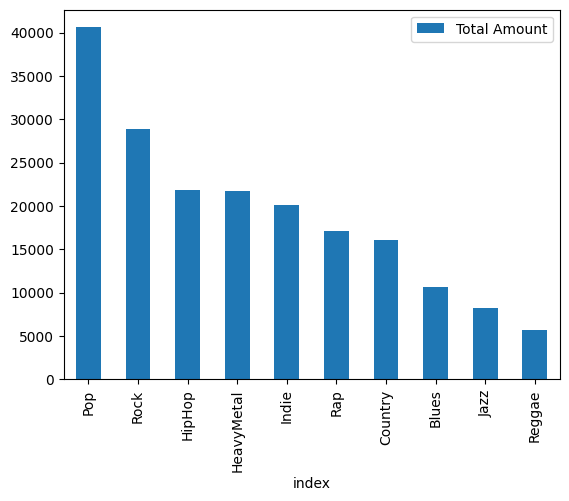

In [ ]:
genre_counts = genres_plus_tcc.iloc[:, 5:].sum(axis=0)
genre_plot = genre_counts.reset_index(name ='Total Amount').sort_values(by='Total Amount', ascending=False).plot.bar(x='index')
# 30s ze 100, kiedy zwraca 429 to sleep

In [ ]:
pop_genre_rows = (genres_plus_tcc[['Blues', 'Country', 'HipHop', 'Jazz', 'Pop', 'Reggae', 'Rock', 'HeavyMetal', 'Indie', 'Rap']] == [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]).all(axis=1)
pop_genre_only_df = genres_plus_tcc[pop_genre_rows]
rows_to_drop = pop_genre_only_df.index[:10000]
genres_plus_tcc.drop(rows_to_drop, inplace=True)

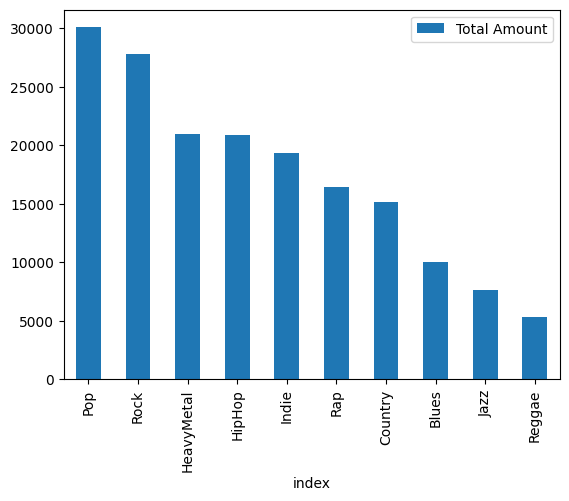

In [ ]:
genre_counts = genres_plus_tcc.iloc[:, 5:].sum(axis=0)
genre_plot = genre_counts.reset_index(name ='Total Amount').sort_values(by='Total Amount', ascending=False).plot.bar(x='index')

> Coraz lepiej 😀 ostatnim datasetem który znalazłyśmy, a który może nam tutaj trochę zbalansować dane jest Multi-Lingual Lyrics for Genre Classification - ten dataset zawiera teksty z wszystkich wyżej wymienionych gatunków, jedynie jego minusem jest to, że nie wszystkie piosenki są po angielsku, ale jakoś temu zaradzimy.

In [ ]:
train_df = pd.read_csv(train_multilungual_dataset)
test_df = pd.read_csv(test_multilungual_dataset)

md_df = pd.concat([train_df, test_df], ignore_index=True)

In [ ]:
en_md_df = md_df[md_df['Language']=='en']

In [ ]:
en_md_df.drop(columns=['Track_id', 'Song year', 'Language'], inplace=True)

<ipython-input-39-97b170f0d917>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_md_df.drop(columns=['Track_id', 'Song year', 'Language'], inplace=True)


In [ ]:
en_md_df = en_md_df[~en_md_df['Genre'].isin(['Rock', 'Pop', 'Folk', 'Electronic'])]

In [ ]:
one_hot_encoded_genres = pd.get_dummies(en_md_df['Genre'])
one_hot_encoded_genres = one_hot_encoded_genres[["Country", "Hip-Hop" ,	"Indie" 	,"Jazz" ,	"Metal" ,	"R&B"]].astype(int)
md_df_with_one_hot_genres = pd.concat([en_md_df, one_hot_encoded_genres], axis=1)


In [ ]:
md_df_with_one_hot_genres.rename(columns={'Song':'SName', 'Lyrics':'Lyric', 'Hip-Hop':'HipHop','Metal':'HeavyMetal','R&B':'Reggae'}, inplace=True)

In [ ]:
md_df_final = md_df_with_one_hot_genres.drop(columns=['Genre'])

In [ ]:
md_df_final['valence']=None
md_df_final['energy']=None

In [ ]:
md_df_final['Blues']=0
md_df_final['Pop']=0
md_df_final['Rock']=0
md_df_final['Rap']=0

In [ ]:
new_order = ['Artist', 'SName', 'Lyric', 'valence', 'energy','Country', 'HipHop', 'Indie', 'Jazz', 'HeavyMetal', 'Reggae','Rock', 'Pop','Blues','Rap' ]
md_df_final = md_df_final[new_order]

In [ ]:
songs_df = pd.concat([md_df_final, genres_plus_tcc])

In [ ]:
songs_df

,Artist,SName,Lyric,valence,energy,Country,HipHop,Indie,Jazz,HeavyMetal,Reggae,Rock,Pop,Blues,Rap
100,3 doors down,here without you,"A hundred days have made me older,\nSince the ...",NaN,NaN,0,0,0,0,1,0,0,0,0,0
101,3 doors down,when i'm gone,There's another world inside of me that you ma...,NaN,NaN,0,0,0,0,1,0,0,0,0,0
102,3 doors down,kryptonite,I took a walk around the world\nTo ease my tro...,NaN,NaN,0,0,0,0,1,0,0,0,0,0
103,3 doors down,let me go,One more kiss could be the best thing\none mor...,NaN,NaN,0,0,0,0,1,0,0,0,0,0
104,3 doors down,be like that,"He spends his nights in California,\nWatching ...",NaN,NaN,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191372,Coldplay,⦵ (Music of the Spheres),[Instrumental]\nMusic of the spheres[Instrumen...,NaN,NaN,0,0,0,0,0,0,0,0,0,0
191373,Matheus Hardke,あなたがいなくて寂しいです(Missyou),Everything breaks down\nIt is inevitable\nBut ...,NaN,NaN,0,0,0,0,0,0,0,0,0,0
191374,Matheus Hardke,イントロ(Intro),Airplanes by the sky\nTonight\nNo makeup in sa...,NaN,NaN,0,0,0,0,0,0,0,0,0,0
191375,Matheus Hardke,追悼に戻る (Back To Mournin'),I don't know what the rules are of it\nBut my ...,NaN,NaN,0,0,0,0,0,0,0,0,0,0


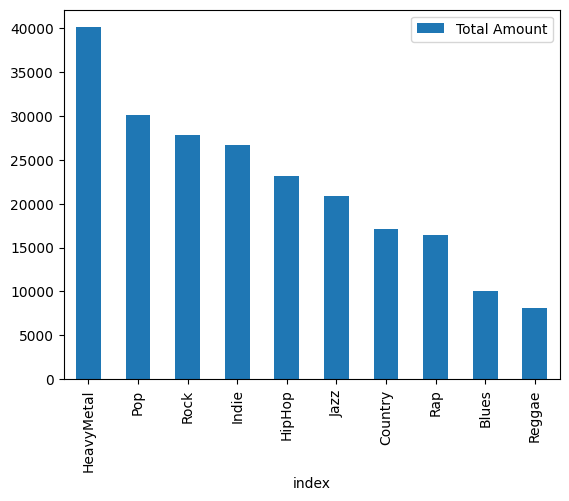

In [ ]:
genre_counts = songs_df.iloc[:, 5:].sum(axis=0)
genre_plot = genre_counts.reset_index(name ='Total Amount').sort_values(by='Total Amount', ascending=False).plot.bar(x='index')

In [ ]:
metal_genre_rows = (songs_df[['Blues', 'Country', 'HipHop', 'Jazz', 'Pop', 'Reggae', 'Rock', 'HeavyMetal', 'Indie', 'Rap']] == [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]).all(axis=1)
metal_genre_only_df = songs_df[metal_genre_rows]
rows_to_drop = metal_genre_only_df.index[:10000]
songs_df.drop(rows_to_drop, inplace=True)

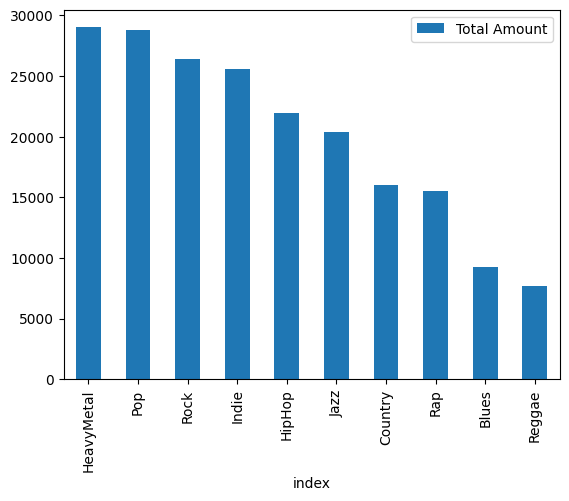

In [ ]:
genre_counts = songs_df.iloc[:, 5:].sum(axis=0)
genre_plot = genre_counts.reset_index(name ='Total Amount').sort_values(by='Total Amount', ascending=False).plot.bar(x='index')

## Usunięcie Blue i Reggae

Na tym etapie postanowiłyśmy wyrzucić Blues i Reggae jako że ich reprezentacja jest na prawdę mała i nie potrafimy znaleźć więcej datasetów, które mogłyby ubogacić te dwa gatunki, dlatego z ciężkim sercem się ich pozbywamy.

In [ ]:
# Drop columns 'Blues' and 'Reggae'
songs_df.drop(columns=['Blues', 'Reggae'], inplace=True)

genre_columns = ['Country', 'HipHop', 'Jazz', 'Pop', 'Rock', 'HeavyMetal', 'Indie', 'Rap']
rows_to_drop = songs_df[(songs_df[genre_columns] == 0).all(axis=1)].index
songs_df.drop(rows_to_drop, inplace=True)

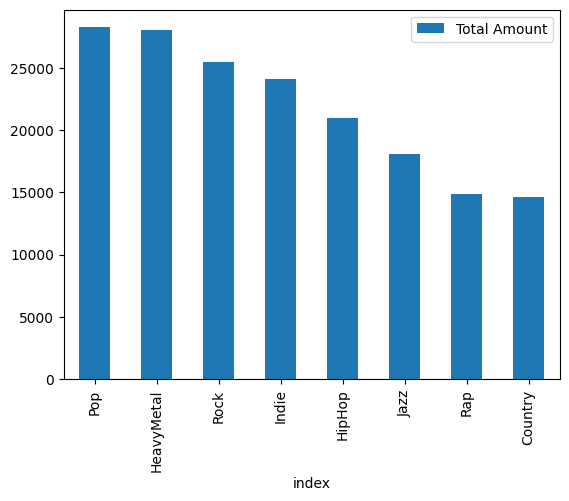

In [ ]:
genre_counts = songs_df.iloc[:, 5:].sum(axis=0)
genre_plot = genre_counts.reset_index(name ='Total Amount').sort_values(by='Total Amount', ascending=False).plot.bar(x='index')

In [ ]:
songs_df.to_csv("/content/drive/MyDrive/Magisterka/songs_data.csv",index=False)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Magisterka/songs_data.csv")
df

,Artist,SName,Lyric,valence,energy,Country,HipHop,Indie,Jazz,HeavyMetal,Rock,Pop,Rap
0,audrye sessions,contagious,Leave now while you can\n'Cause growing old ju...,NaN,NaN,0,0,1,0,0,0,0,0
1,audrye sessions,dust and bones,"We've been poisoned\ntracked down, herded\nto ...",NaN,NaN,0,0,1,0,0,0,0,0
2,audrye sessions,new year's day,"The needle's in hand,\nbut I cannot sew.\nMy h...",NaN,NaN,0,0,1,0,0,0,0,0
3,audrye sessions,perfect sometimes,I catch every whisper\nSurrounding your head\n...,NaN,NaN,0,0,1,0,0,0,0,0
4,audrye sessions,relentless,"Get off of work, come home,\npass out.\nMy lif...",NaN,NaN,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134088,Danny Brown,​uknowhatimsayin¿ (Ft. Obongjayar),"Clock tickin', know you can't be playin'\nKnow...",NaN,NaN,0,1,0,0,0,0,0,0
134089,Taylor Swift,​willow (Dancing witch version) (Elvira remix),I'm like the water when your ship rolled in th...,NaN,NaN,0,0,0,0,0,0,1,0
134090,Fleet Foxes,"– Naiads, Cassadies","[The storm suddenly breaks]\n[In a car, on the...",NaN,NaN,0,0,1,0,0,0,0,0
134091,Babymetal,↑↓←→BBAB,Game Over or Continue？\nDon't give up mōsugu-s...,NaN,NaN,0,0,0,0,1,1,0,0


Zauważyłam, że niektore piosenki nie są po ang, let's do a check:

In [ ]:
! pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=648d55b8ee7a07642f7d278a119e7190b75381a719fa004ae5d0fcd2d1a0b580
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

In [ ]:
from tqdm import tqdm

In [ ]:
def detect_language_with_progress(text):
    try:
        lang = detect(text)
        return lang == 'en'  # Return True if language is English, False otherwise
    except LangDetectException:
        return False  # Return False if language detection fails

# Apply language detection with tqdm
tqdm.pandas(desc="Detecting Language")
df['Lyric_is_english'] = df['Lyric'].progress_apply(detect_language_with_progress)

# Check if all lyrics are in English
all_lyrics_in_english = df['Lyric_is_english'].all()

Detecting Language: 100%|██████████| 134093/134093 [35:50<00:00, 62.35it/s]


In [ ]:
df = df[df['Lyric_is_english'] == True]

In [ ]:
#df.to_csv("/content/drive/MyDrive/Magisterka/en_songs_data.csv", index=False)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Magisterka/en_songs_data.csv")

In [ ]:
df.drop(columns=['Lyric_is_english'], inplace=True)

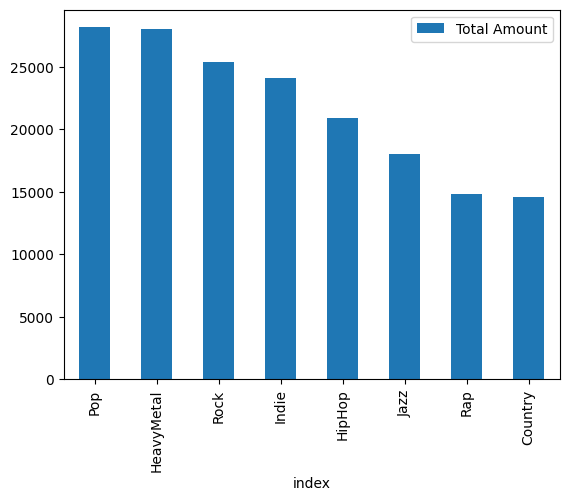

In [ ]:
genre_counts = df.iloc[:, 5:].sum(axis=0)
genre_plot = genre_counts.reset_index(name ='Total Amount').sort_values(by='Total Amount', ascending=False).plot.bar(x='index')

## Pre-processing dla NLP

Teraz należy usunąć wszystkie niepotrzebne znaki. Potem zabraliśmy się za stemming/lemmatyzację i usuwanie stopwords.



In [ ]:
import string

def preprocess_for_nlp(data: pd.DataFrame) -> pd.DataFrame:
  punctuation_to_remove = string.punctuation.replace("'", "")
  data["Lyric"] = data["Lyric"].str.lower()
  data["Lyric"] = data["Lyric"].str.replace('chorus','')
  data["Lyric"] = data['Lyric'].str.replace('verse','')
  data['Lyric'] = data['Lyric'].str.replace(f"[{punctuation_to_remove}]", "", regex=True)
  data["Lyric"] = data['Lyric'].str.replace('2x','')
  data["Lyric"] = data['Lyric'].str.replace('x2','')
  data["Lyric"] = data['Lyric'].str.replace('3x','')
  data["Lyric"] = data['Lyric'].str.replace('x3','')
  data["Lyric"] = data['Lyric'].str.replace('4x','')
  data["Lyric"] = data['Lyric'].str.replace('x4','')
  data["Lyric"] = data['Lyric'].str.replace('5x','')
  data["Lyric"] = data['Lyric'].str.replace('x5','')
  data["Lyric"] = data['Lyric'].str.replace('6x','')
  data["Lyric"] = data['Lyric'].str.replace('x6','')
  data["Lyric"] = data['Lyric'].str.replace('7x','')
  data["Lyric"] = data['Lyric'].str.replace('x7','')
  data["Lyric"] = data['Lyric'].str.replace('8x','')
  data["Lyric"] = data['Lyric'].str.replace('x8','')
  data["Lyric"] = data['Lyric'].str.replace('9x','')
  data["Lyric"] = data['Lyric'].str.replace('x9','')
  data["Lyric"] = data["Lyric"].str.replace('\n', ' ')
  data["Lyric"] = data["Lyric"].str.replace(r'\s+', ' ', regex=True).str.strip()
  return data

In [ ]:
df['Lyric'][200]

"Yeah, yeah, yeah, yeah [4x]\nWe started out good friends\nSaid you're the kind of man that\nTakes every girl for a fool.\nShoot, shoot, shoot\nA fantastic into romantic [say what?]\nRomantic into fantastic.\nWe came here to rock the microphone.\nWe came here to rock the microphone.\nOur aim is to break you down to the bone.\nOur aim is to break you down to the bone.\nLets talk about [4x]\nWe started out good friends\nSaid you're the kind of man that\nTakes every girl for a fool.\nWe came here to rock the microphone.\nWe came here to rock the microphone.\nOur aim is to break you down to the bone.\nOur aim is to break you down to the bone\n[2x]\nYeah, yeah, yeah, yeah [4x]"

In [ ]:
df_pre = preprocess_for_nlp(data=df)

In [ ]:
df_pre['Lyric'][200]

"yeah yeah yeah yeah we started out good friends said you're the kind of man that takes every girl for a fool shoot shoot shoot a fantastic into romantic say what romantic into fantastic we came here to rock the microphone we came here to rock the microphone our aim is to break you down to the bone our aim is to break you down to the bone lets talk about we started out good friends said you're the kind of man that takes every girl for a fool we came here to rock the microphone we came here to rock the microphone our aim is to break you down to the bone our aim is to break you down to the bone yeah yeah yeah yeah"

Jak widać zostały usunięte wszystkie znaki specjalne, jak i też np znaki powtórzenia x2, x3... oraz takie słowa jak np. chorus czy verse oraz zbędne spacje.

### Handling contractions

In [ ]:
! pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
import contractions

tqdm.pandas(desc="Handling contractions")

def handle_contractions(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data['Lyric'] = data['Lyric'].progress_apply(lambda x: contractions.fix(x))
    return data

df_without_contractions = handle_contractions(df_pre)

Handling contractions: 100%|██████████| 133733/133733 [00:58<00:00, 2276.28it/s]


In [ ]:
df_pre['Lyric'][200]

"yeah yeah yeah yeah we started out good friends said you're the kind of man that takes every girl for a fool shoot shoot shoot a fantastic into romantic say what romantic into fantastic we came here to rock the microphone we came here to rock the microphone our aim is to break you down to the bone our aim is to break you down to the bone lets talk about we started out good friends said you're the kind of man that takes every girl for a fool we came here to rock the microphone we came here to rock the microphone our aim is to break you down to the bone our aim is to break you down to the bone yeah yeah yeah yeah"

In [ ]:
df_without_contractions['Lyric'][200]

'yeah yeah yeah yeah we started out good friends said you are the kind of man that takes every girl for a fool shoot shoot shoot a fantastic into romantic say what romantic into fantastic we came here to rock the microphone we came here to rock the microphone our aim is to break you down to the bone our aim is to break you down to the bone let us talk about we started out good friends said you are the kind of man that takes every girl for a fool we came here to rock the microphone we came here to rock the microphone our aim is to break you down to the bone our aim is to break you down to the bone yeah yeah yeah yeah'

In [ ]:
#df_without_contractions.to_csv("/content/drive/MyDrive/Magisterka/pre_processed_songs_data.csv", index=False)